本文希望通过机器学习的方法构造与股价涨幅相关性更高的因子，并尝试根据树回归模型预测未来股价涨幅。此种方法建立在如下两个假设之上：
假设1：股价属于非随机游走时间序列，有一定可预测性，否则所有因子分析都是无效的。
假设2：不同时段的因子有效性是变化的，而因子有效性会持续一段时间。比如这个月市盈率低的股票有更多资金涌入，而下个月市盈率高的股票更受青睐。如果假设成立，那么使用固定公式计算股价是局限的。我们希望用机器学习找出资金的暂时性逻辑。

股票池选取的条件是沪股通深股通持股比例大于1%。

## 目录
### 1. 数据清洗
### 2. 特征组合
### 3. 数据回测

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jqdata import *

### 1. 数据清洗

In [2]:
# 选取[START, END]时间段内的数据集，包括训练集和测试集
START = "2019-03-01"
END = "2019-07-01"

In [48]:
# 选取深股通与沪股通持股比例大于1%的A股股票构建股票池
q = query(finance.STK_HK_HOLD_INFO).filter(
        finance.STK_HK_HOLD_INFO.link_id.in_([310001,310002]),
        finance.STK_HK_HOLD_INFO.day=="2019-03-20",
        finance.STK_HK_HOLD_INFO.share_ratio>1)
stock_list = finance.run_query(q)["code"]

In [4]:
# 新增特征：沪深三百指数涨幅
price_hs300 = get_price("000300.XSHG", 
                  start_date=START, end_date=END, 
                  panel=False)
# 沪深三百指数前两天/五天/十天涨幅
price_hs300["x_2d"] = (price_hs300["close"]-price_hs300["close"].shift(2))/price_hs300["close"].shift(2)
price_hs300["x_5d"] = (price_hs300["close"]-price_hs300["close"].shift(5))/price_hs300["close"].shift(5)
price_hs300["x_10d"] = (price_hs300["close"]-price_hs300["close"].shift(10))/price_hs300["close"].shift(10)
# 沪深三百指数后两天/五天/十天涨幅
price_hs300["y_2d"] = (price_hs300["close"].shift(-2)-price_hs300["close"])/price_hs300["close"]
price_hs300["y_5d"] = (price_hs300["close"].shift(-5)-price_hs300["close"])/price_hs300["close"]
price_hs300["y_10d"] = (price_hs300["close"].shift(-10)-price_hs300["close"])/price_hs300["close"]

In [5]:
# 将stock_list中的所有股票价格-时间序列合并到一张DataFrame表里
price_concat = pd.DataFrame()

for stock in stock_list:
    price = get_price(stock, 
                  start_date=START, end_date=END, 
                  panel=False)
    # 新增特征：个股前两天/五天/十天涨幅
    price["x_2d"] = (price["close"]-price["close"].shift(2))/price["close"].shift(2)
    price["x_5d"] = (price["close"]-price["close"].shift(5))/price["close"].shift(5)
    price["x_10d"] = (price["close"]-price["close"].shift(10))/price["close"].shift(10)
    # 当天收盘价 - 开盘价
    price["c-o"] = (price["close"] - price["open"])/price["open"]
    # 振幅：当天最高价 - 最低价
    price["h-l"] = (price["high"] - price["low"])/price["low"]
    # 个股后两天/五天/十天涨幅
    price["y_2d"] = (price["close"].shift(-2)-price["close"])/price["close"]
    price["y_5d"] = (price["close"].shift(-5)-price["close"])/price["close"]
    price["y_10d"] = (price["close"].shift(-10)-price["close"])/price["close"]
    # 相对涨幅：个股前两天/五天/十天涨幅 - 沪深三百指数涨幅
    price["x_2d-hs300"] = price["x_2d"] - price_hs300["x_2d"]
    price["x_5d-hs300"] = price["x_5d"] - price_hs300["x_5d"]
    price["x_10d-hs300"] = price["x_10d"] - price_hs300["x_10d"]
    # 需要拟合的y值：个股后两天/五天/十天相对涨幅
    price["y_2d-hs300"] = price["y_2d"] - price_hs300["y_2d"]
    price["y_5d-hs300"] = price["y_5d"] - price_hs300["y_5d"]
    price["y_10d-hs300"] = price["y_10d"] - price_hs300["y_10d"]
    # 大单/中单/小单净额表
    mf = get_money_flow(stock, START, END)[["date", "sec_code", "net_amount_main", "net_amount_s"]]
    # 新增特征：前两天/五天/十天大单总净额
    mf["net_main_2d"] = mf["net_amount_main"].rolling(window=2).sum()
    mf["net_main_5d"] = mf["net_amount_main"].rolling(window=5).sum()
    mf["net_main_10d"] = mf["net_amount_main"].rolling(window=10).sum()
    # # 新增特征：前两天/五天/十天小单总净额
    mf["net_s_2d"] = mf["net_amount_s"].rolling(window=2).sum()
    mf["net_s_5d"] = mf["net_amount_s"].rolling(window=5).sum()
    mf["net_s_10d"] = mf["net_amount_s"].rolling(window=10).sum()
    
    price = pd.merge(price, mf, left_index=True, right_on=["date"])
    # 新增特征：行业分类
    price["industry"] = get_industry(stock)[stock]["zjw"]["industry_code"]
    
    price_concat = pd.concat([price_concat, price])

In [6]:
df_price = price_concat.drop(["open", "close", "high", "low"], axis=1)
df_price = df_price.rename(columns={"date":"time", "sec_code": "code"})

In [42]:
price_concat.dropna()[["date", "sec_code","close","y_2d-hs300","y_5d-hs300","y_10d-hs300"]].sort_values(by="y_10d-hs300")

,date,sec_code,close,y_2d-hs300,y_5d-hs300,y_10d-hs300
56,2019-05-27,600518.XSHG,5.11,-0.105191,-0.223622,-0.423741
37,2019-04-24,600518.XSHG,11.54,-0.059512,-0.174243,-0.412068
55,2019-05-24,600518.XSHG,5.38,-0.120314,-0.234891,-0.406170
38,2019-04-25,600518.XSHG,10.99,-0.030421,-0.244169,-0.406084
39,2019-04-26,600518.XSHG,10.45,-0.098021,-0.280768,-0.399449
54,2019-05-23,600518.XSHG,5.66,-0.112028,-0.240347,-0.395681
53,2019-05-22,600518.XSHG,5.96,-0.082116,-0.230492,-0.386684
36,2019-04-23,600518.XSHG,11.74,-0.044678,-0.165328,-0.384760
52,2019-05-21,600518.XSHG,6.27,-0.074702,-0.227970,-0.381690
57,2019-05-28,600518.XSHG,4.85,-0.086382,-0.204648,-0.378326


In [7]:
# 北向资金持股信息表；将stock_list中的所有股票整合到一张DataFrame里
df_hk = pd.DataFrame()
for stock in stock_list:
    q = query(finance.STK_HK_HOLD_INFO).filter(
        finance.STK_HK_HOLD_INFO.code==stock,
        finance.STK_HK_HOLD_INFO.day>=START,
        finance.STK_HK_HOLD_INFO.day<=END)
    stk_hk = finance.run_query(q)
    stk_hk = stk_hk.rename(columns={"day":"time"})
    # 北向资金前两天/五天/十天持股数/比例增幅
    stk_hk["sharenum_hk_2d"] = stk_hk["share_number"]-stk_hk["share_number"].shift(2)
    stk_hk["sharenum_hk_5d"] = stk_hk["share_number"]-stk_hk["share_number"].shift(5)
    stk_hk["sharenum_hk_10d"] = stk_hk["share_number"]-stk_hk["share_number"].shift(10)
    stk_hk["shareratio_hk_2d"] = stk_hk["share_ratio"]-stk_hk["share_ratio"].shift(2)
    stk_hk["shareratio_hk_5d"] = stk_hk["share_ratio"]-stk_hk["share_ratio"].shift(5)
    stk_hk["shareratio_hk_10d"] = stk_hk["share_ratio"]-stk_hk["share_ratio"].shift(10)

    stk_hk = stk_hk.drop(["id", "link_id", "link_name", "name", "share_number", "share_ratio"], axis=1)
    stk_hk["time"] = pd.to_datetime(stk_hk["time"])
    df_hk = pd.concat([df_hk, stk_hk])

In [8]:
# 合并北向资金持股特征到df_price表中，右连接-以A股交易日为合并基准
df_time = pd.merge(df_hk, df_price, how='right', on=["code", "time"]).sort_values(
            by=["time", "code"], ascending=["True", "True"])

In [9]:
# A股交易日列表 [START, END]
date_list = price_hs300.index

In [10]:
# 技术指标
from jqlib.technical_analysis import *

In [12]:
# 将各类股票特征按照date_list中的日期合并到一个DataFrame表中
# 这一步耗时较长
df = pd.DataFrame()

for i in range(len(date_list)):
    q = query(valuation.code, valuation.market_cap, valuation.pcf_ratio, 
          valuation.pb_ratio, valuation.pe_ratio, valuation.pe_ratio_lyr, 
          income.basic_eps, income.total_profit, income.operating_revenue, 
          income.operating_cost, income.operating_profit).filter(
            valuation.code.in_(stock_list),
            )
    factor = get_fundamentals(q, date_list[i])
    factor["time"] = date_list[i]
    print(i/len(date_list))
    # 技术指标列表
    tech = pd.DataFrame({"rsi":pd.Series(RSI(stock_list, date_list[i])),
                  "roc":pd.Series(ROC(stock_list,date_list[i])), 
                  "expma":pd.Series(EXPMA(stock_list, date_list[i])),
                  "bbi":pd.Series(BBI(stock_list, date_list[i])),
                  "hsl":HSL(stock_list, date_list[i])[0],
                  "mahsl":HSL(stock_list, date_list[i])[1],
                  "bias1":BIAS(stock_list, date_list[i])[0],
                  "bias2":BIAS(stock_list, date_list[i])[1],
                  "bias3":BIAS(stock_list, date_list[i])[2],
                  "smg_zy1":SG_SMX('399001.XSHE',stock_list.tolist(),check_date=date_list[i],N=50)[0],
                  "smg_zy2":SG_SMX('399001.XSHE',stock_list.tolist(),check_date=date_list[i],N=50)[1],
                  "smg_zy3":SG_SMX('399001.XSHE',stock_list.tolist(),check_date=date_list[i],N=50)[2]})
    factor = pd.merge(factor, tech, left_on=["code"], right_index=True)
    df = pd.concat([df, factor])

0.0
0.012195121951219513
0.024390243902439025
0.036585365853658534
0.04878048780487805
0.06097560975609756
0.07317073170731707
0.08536585365853659
0.0975609756097561
0.10975609756097561
0.12195121951219512
0.13414634146341464
0.14634146341463414
0.15853658536585366
0.17073170731707318
0.18292682926829268
0.1951219512195122
0.2073170731707317
0.21951219512195122
0.23170731707317074
0.24390243902439024
0.25609756097560976
0.2682926829268293
0.2804878048780488
0.2926829268292683
0.3048780487804878
0.3170731707317073
0.32926829268292684
0.34146341463414637
0.35365853658536583
0.36585365853658536
0.3780487804878049
0.3902439024390244
0.4024390243902439
0.4146341463414634
0.4268292682926829
0.43902439024390244
0.45121951219512196
0.4634146341463415
0.47560975609756095
0.4878048780487805
0.5
0.5121951219512195
0.524390243902439
0.5365853658536586
0.5487804878048781
0.5609756097560976
0.573170731707317
0.5853658536585366
0.5975609756097561
0.6097560975609756
0.6219512195121951
0.63414634146341

In [13]:
df.shape

(36237, 24)

In [14]:
# 将股价时间序列表（df_time）与股票特征表(df)合并
df_all = pd.merge(df, df_time, on=["code", "time"]).sort_values(
            by=["time", "code"], ascending=["True", "True"])

In [15]:
df_all.dropna().shape

(24241, 55)

In [150]:
# 各个特征与y值的相关度列表
df_corr = df_all.dropna().corr()[["y_2d-hs300", "y_5d-hs300", "y_10d-hs300"]]
df_corr.sort_values(by="y_10d-hs300")

,y_2d-hs300,y_5d-hs300,y_10d-hs300
mahsl,-0.032216,-0.046018,-0.095392
hsl,-0.039937,-0.049062,-0.088223
roc,-0.024362,-0.032686,-0.072259
rsi,-0.021614,-0.047604,-0.067942
bias2,-0.029588,-0.042577,-0.061642
x_10d,-0.013853,-0.039329,-0.060626
bias3,-0.025595,-0.037138,-0.059815
bias1,-0.028206,-0.042523,-0.044585
x_5d,-0.025233,-0.036859,-0.042205
volume,-0.014402,-0.020494,-0.035842


In [25]:
# 提取相关性较强的特征名列表，为下一步特征组合做准备
index_corr = df_corr[(abs(df_corr["y_10d-hs300"])>0.05)&(abs(df_corr["y_10d-hs300"])<0.25)].index

In [19]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [20]:
# X, y 训练集；Xt, yt 测试集
def rmse(model, X, y, Xt, yt):
    model.fit(X, y)
    y_pre = model.predict(X)
    score = np.sqrt(np.inner(y-y_pre, y-y_pre)/len(y))
    
    y_pre_test = model.predict(Xt)
    score_test = np.sqrt(np.inner(yt-y_pre_test, yt-y_pre_test)/len(yt))
    
    return (y_pre, score, y_pre_test, score_test)

## 2. 特征组合

In [21]:
df1 = df_all.dropna()

In [26]:
from sklearn.preprocessing import PolynomialFeatures
# 以polynomial作特征相乘，指数设置为2
poly = PolynomialFeatures(degree=2, interaction_only=True)
adding = poly.fit_transform(df1[index_corr])

df_poly = pd.DataFrame(adding, columns=poly.get_feature_names(), index=df1.index)
df_poly.shape

(24241, 67)

In [27]:
# 将新的特征组合合并到df2表中
df2 = pd.concat([df1, df_poly], axis=1)
df2.shape

(24241, 122)

In [140]:
# 训练集和测试集分为4：1
n = int(len(df2)/4*3)
train = df2[:n]
test = df2[n:]

train2 = train.drop(["time", "code"], axis=1)
train2 = pd.get_dummies(train2)

test2 = test.drop(["time", "code"], axis=1)
test2 = pd.get_dummies(test2)

In [141]:
df2.corr()[["y_2d-hs300", "y_5d-hs300", "y_10d-hs300"]].sort_values(by="y_2d-hs300")

,y_2d-hs300,y_5d-hs300,y_10d-hs300
x1 x4,-0.040289,-0.049641,-0.087893
x4,-0.039937,-0.049062,-0.088223
hsl,-0.039937,-0.049062,-0.088223
x1 x5,-0.033625,-0.050472,-0.098810
x5,-0.032216,-0.046018,-0.095392
mahsl,-0.032216,-0.046018,-0.095392
bias2,-0.029588,-0.042577,-0.061642
x6,-0.029588,-0.042577,-0.061642
x4 x6,-0.028259,-0.023525,-0.044679
bias1,-0.028206,-0.042523,-0.044585


In [142]:
# 标准化
scaler = preprocessing.RobustScaler() 
X = train2.drop(["y_2d", "y_5d", "y_10d", "y_2d-hs300", "y_5d-hs300", "y_10d-hs300"], axis=1)
y = train2["y_10d-hs300"]

X_test = test2.drop(["y_2d", "y_5d", "y_10d", "y_2d-hs300", "y_5d-hs300", "y_10d-hs300"], axis=1)
y_test = test2["y_10d-hs300"]
    
X_scaled = scaler.fit(X).transform(X)
X_test_scaled = scaler.transform(X_test)

In [143]:
# 测试集预测结果放在 test['yypre']一栏中
result = rmse(RandomForestRegressor(), X_scaled, y, X_test_scaled, y_test)
test.loc[:, 'yypre'] = pd.Series(result[2], index=test.index)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [144]:
test[["y_2d-hs300", "y_5d-hs300","y_10d-hs300", "yypre"]].corr()

,y_2d-hs300,y_5d-hs300,y_10d-hs300,yypre
y_2d-hs300,1.000000,0.622675,0.447465,0.141712
y_5d-hs300,0.622675,1.000000,0.697653,0.183667
y_10d-hs300,0.447465,0.697653,1.000000,0.195126
yypre,0.141712,0.183667,0.195126,1.000000


In [148]:
# 取预测后十日涨幅最大的前30只股票，去重
df_final = test[["time", "code","y_10d-hs300", "yypre"]].sort_values(by="yypre", ascending=False)
df_final.code[:30].drop_duplicates().values

array([002714.XSHE, 000876.XSHE, 600990.XSHG, 600584.XSHG, 600779.XSHG,
       002157.XSHE, 603288.XSHG, 600261.XSHG, 002299.XSHE, 300347.XSHE,
       601038.XSHG, 000401.XSHE, 600004.XSHG, 000651.XSHE, 000858.XSHE],
      dtype=object)

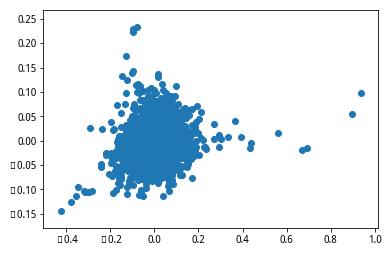

In [149]:
plt.scatter(test["y_10d-hs300"], test["yypre"])